In [1]:
import utils
from ortools.sat.python import cp_model
import pandas as pd
from params import *
import datetime
from itertools import islice
from workalendar.asia import Malaysia
malaysia = Malaysia()

In [2]:
shifts = [am, ams, pm, n]
leaves = [no, do, al, dop]
date_range = utils.date_range(start=(2022,7,11), end=(2022,7,24))

In [3]:
df = pd.read_excel('jadual_data/data.xlsx', index_col=0)
prev_roster_date_range = list(df.columns.to_pydatetime())
prev_roster = utils.get_data_to_tuple('jadual_data/data.xlsx')

In [4]:
requests = utils.get_request_to_tuple('jadual_data/request.xlsx')

In [5]:
class Model:
    def __init__(self, _nurses, _roles, _shifts, _leaves, _date_range, _prev_roster,_prev_roster_date_range=None):
        self.model = cp_model.CpModel()
        self._nurses = _nurses
        self._roles = _roles
        self._shifts = _shifts
        self._leaves = _leaves
        self._date_range = _date_range
        self._prev_roster = _prev_roster
        self.collect_penalty()
        
        self._prev_roster_date_range = _prev_roster_date_range
        self._total_date_range = _date_range if _prev_roster_date_range is None else _prev_roster_date_range + _date_range
        self._works = {}
        self._slots = _shifts + _leaves
        self.obj_bool_vars_max = []
        self.obj_bool_coeffs_max = []
        self.obj_bool_vars_min = []
        self.obj_bool_coeffs_min = []
        
        self.obj_int_vars_max = []
        self.obj_int_coeffs_max = []
        self.obj_int_vars_min = []
        self.obj_int_coeffs_min = []
        self.logs = ''

################################################################################################
######################################        Init       #######################################
################################################################################################

        for nurse in self._nurses:
            for s in self._slots:
                for d in self._total_date_range:
                    self._works[(nurse, s, d)] = self.model.NewBoolVar(f'work_{nurse}_{s}_{d}')
                    
        for nurse in self._nurses:
            for d in self._date_range:
                self.model.AddExactlyOne(self._works[(nurse, s, d)] for s in self._slots)
                
################################################################################################
######################################      Logger       #######################################
################################################################################################

    def logger(self, text):
        self.logs += f'\n{text}'

################################################################################################
######################################      Off day      #######################################
################################################################################################
    
    def off_day_per_week(self, day=1):
        for nurse in self._nurses:
            for i, a_week in enumerate(utils.chunk(self._date_range, 7)):
                try:
                    self.model.Add(sum(self._works[(nurse, do, d)] for d in a_week) == day)
                except:
                    self.logger(f'no index, {nurse}, {i}')
                    
    def public_holiday(self):
        check_dop = [d for d in self._total_date_range if malaysia.is_holiday(d)]
        for nurse in self._nurses:
            try:
                self.model.Add(sum(self._works[(nurse, dop, d)] for d in self._total_date_range) < len(check_dop)+1)
            except:
                self.logger(f'no index, {nurse}')
                
            for d in self._date_range:
                if malaysia.is_working_day(d):
                    try:
                        self.model.Add(self._works[(nurse, dop, d)] == 0)
                    except:
                        self.logger(f'no index, {nurse}')

################################################################################################
######################################     Demand covers    ####################################
################################################################################################
    
    def number_workers_per_shift(self):
        for d in self._date_range:
            # night
            self.model.Add(sum(self._works[(nurse, n, d)] for nurse in self._nurses) == 1)
            # self.model.Add(sum(self._works[(nurse, no, d)] for nurse in self._nurses) >= 0)
            
            if malaysia.is_working_day(d):
                # am
                self.model.Add(sum(self._works[(nurse, morning, d)] for nurse in self._nurses for morning in [am, ams]) >= 2)
                # pm
                self.model.Add(sum(self._works[(nurse, pm, d)] for nurse in self._nurses) == 3)
                # ams
                self.model.Add(sum(self._works[(nurse, ams, d)] for nurse in self._nurses) > 0)
                self.model.Add(sum(self._works[(nurse, ams, d)] for nurse in self._nurses) <= 2)
                # if utils.is_saturday(d) and not malaysia.is_holiday(d):
                #     self.model.Add(sum(self._works[(nurse, am, d)] for nurse in self._nurses) >= 1)
                # else:
                #     self.model.Add(sum(self._works[(nurse, am, d)] for nurse in self._nurses) == 1)
                
                
#             if utils.is_saturday(d):
#                 # am
#                 self.model.Add(sum(self._works[(nurse, am, d)] for nurse in self._nurses) >= 1)
#                 # pm
#                 self.model.Add(sum(self._works[(nurse, pm, d)] for nurse in self._nurses) == 1)
#                 # ams
#                 self.model.Add(sum(self._works[(nurse, ams, d)] for nurse in self._nurses) == 0)
                
#             if utils.is_sunday(d):
#                 # am
#                 self.model.Add(sum(self._works[(nurse, am, d)] for nurse in self._nurses) == 1)
#                 # pm
#                 self.model.Add(sum(self._works[(nurse, pm, d)] for nurse in self._nurses) == 1)
            
            else:
                self.model.Add(sum(self._works[(nurse, am, d)] for nurse in self._nurses) == 1)
                # pm
                self.model.Add(sum(self._works[(nurse, pm, d)] for nurse in self._nurses) == 1)
                # ams
                self.model.Add(sum(self._works[(nurse, ams, d)] for nurse in self._nurses) == 0)
                # am
            # dop
            # if malaysia.is_holiday(d):
            #     self.model.Add(sum(self._works[(nurse, dop, d)] for nurse in self._nurses) >= 0)
            # else:
            #     self.model.Add(sum(self._works[(nurse, dop, d)] for nurse in self._nurses) == 0)

                
################################################################################################
###################################    Previous roster init    #################################
################################################################################################
    
    def previous_roster(self, day_1_data: list):
        for nurse in self._nurses:
            for s in self._slots:
                for d in self._total_date_range:
                    if (nurse, s, d) in day_1_data:
                        self.model.Add(self._works[(nurse, s, d)] == 1)
                        # self.model.AddHint(self._works[(nurse, s, d)], 1)
                    # else:
                    #     self.model.Add(self._works[(nurse, s, d)] == 0)
        # for nurse, s, d in day_1_data:
        #     try:
        #         self.model.Add(self._works[(nurse, s, d)] == 1)
        #     except:
        #         self.logger(f'no index, {nurse}, {s}')


################################################################################################
######################################      Requests     #######################################
################################################################################################

    def requests(self, requests):
        # for (nurse, al, d) in requests:
        #     self.model.Add(self._works[(nurse, al, d)] == 1)
        for nurse in self._nurses:
            for d in self._date_range:
                # self.model.Add(self._works[(nurse, al, d)] == 0)
                try:
                    if (nurse, al, d) in requests:
                        self.model.Add(self._works[(nurse, al, d)] == 1)
                        # self.obj_bool_vars_min.append(self._works[(nurse, al, d)])
                        # self.obj_bool_coeffs_min.append(500)
                    else:
                        self.model.Add(self._works[(nurse, al, d)] == 0)
                except:
                    print('error')
                
################################################################################################
######################################      Seniority     ######################################
################################################################################################

    def sum_seniority(self, roles):
        senior_nurses = [name for name, role in roles.items() if role == senior]
        for d in self._date_range:
            if utils.is_weekday(d):
                self.model.Add(sum(self._works[(nurse, pm, d)] for nurse in senior_nurses) > 0)
                # self.model.Add(sum(self._works[(nurse, pm, d)] for nurse in senior_nurses) <= 2)
                self.model.Add(sum(self._works[(nurse, morning, d)] for nurse in senior_nurses for morning in [am, ams]) > 0)
                # self.model.Add(sum(self._works[(nurse, morning, d)] for nurse in senior_nurses for morning in [am, ams]) <= 2)
            
################################################################################################
######################################      Sum constraints     ################################
################################################################################################

    def implement_sum_constraint(self, sum_constraints):        
        for sum_const in sum_constraints: # need to build data model
            slot, slot_type, hard_min, soft_min, min_cost, soft_max, hard_max, max_cost = sum_const
            for nurse in self._nurses:
                dates = utils.chunk(self._total_date_range, 7) if slot_type == "weekly" else [self._total_date_range[:28]]
                for index, week in enumerate(dates):
                    self.sum_constraint(
                        nurse, 
                        slot,
                        week,
                        index,
                        hard_min, 
                        soft_min, 
                        min_cost, 
                        soft_max,
                        hard_max, 
                        max_cost
                    )
                            
    def sum_constraint(
        self,
        nurse, 
        slot, 
        date_list, 
        date_list_index,
        hard_min, 
        soft_min, 
        min_cost, 
        soft_max,
        hard_max, 
        max_cost
    ):
        try:
            works = [self._works[(nurse, slot, d)] for d in date_list]
            prefix = f'weekly_sum_constraint({nurse}, {slot}, {date_list_index})'
            variables, coeffs = utils.add_soft_sum_constraint(
                self.model, 
                works, 
                hard_min, 
                soft_min, 
                min_cost, 
                soft_max,
                hard_max, 
                max_cost, 
                prefix
            )
            self.obj_int_vars_min.extend(variables)
            self.obj_int_coeffs_min.extend(coeffs)
        except Exception as e:
            self.logger(f'{e}, outside of range')

################################################################################################
######################################      Objective     ######################################
################################################################################################


    def maximize(self):
        self.model.Maximize(
            sum(self.obj_bool_vars_max[i] * self.obj_bool_coeffs_max[i]
                for i in range(len(self.obj_bool_vars_max))) +
            sum(self.obj_int_vars_max[i] * self.obj_int_coeffs_max[i]
                for i in range(len(self.obj_int_vars_max)))
        )
        
    def minimize(self):
        self.model.Minimize(
            sum(self.obj_bool_vars_min[i] * self.obj_bool_coeffs_min[i]
            for i in range(len(self.obj_bool_vars_min))) +
            sum(self.obj_int_vars_min[i] * self.obj_int_coeffs_min[i]
                for i in range(len(self.obj_int_vars_min)))
        )


################################################################################################
######################################      SOLVE         ######################################
################################################################################################
    
    def solve(self, search_all=True):
        self.solver = cp_model.CpSolver()
        self.solver.parameters.enumerate_all_solutions = search_all
        self.solution_printer = cp_model.ObjectiveSolutionPrinter()
        self.status = self.solver.Solve(self.model, self.solution_printer)
        self.solution = {}
        self.current_solution = []
        if self.status == cp_model.OPTIMAL or self.status == cp_model.FEASIBLE:
            print()
            header = '   \t'
            for d in self._total_date_range:
                header += f'{d.strftime("%d-%m")}\t'
            print(header)
            for nurse in self._nurses:
                schedule = ''
                
                for d in self._total_date_range:
                    for s in self._slots:
                        if self.solver.BooleanValue(self._works[nurse, s, d]) == 1:
                            schedule += s + '\t'
                            
                for d in self._date_range:
                    for s in self._slots:
                        if self.solver.BooleanValue(self._works[nurse, s, d]) == 1:
                            self.solution.setdefault(nurse,[])
                            self.solution[nurse].append(s)
                            self.current_solution.append((nurse, s, d))
                            
                print(f'{nurse}:   \t{schedule}')
            print()
            print('Penalties:')
            for i, var in enumerate(self.obj_bool_vars_min):
                if self.solver.BooleanValue(var):
                    penalty = self.obj_bool_coeffs_min[i]
                    if penalty > 0:
                        print('  %s violated, penalty=%i' % (var.Name(), penalty))
                    else:
                        print('  %s fulfilled, gain=%i' % (var.Name(), -penalty))
                        
            for i, var in enumerate(self.obj_bool_vars_max):
                if self.solver.BooleanValue(var):
                    penalty = self.obj_bool_coeffs_max[i]
                    if penalty > 0:
                        print('  %s fulfilled, gain=%i' % (var.Name(), penalty))
                    else:
                        print('  %s violated, penalty=%i' % (var.Name(), -penalty))

            for i, var in enumerate(self.obj_int_vars_min):
                if self.solver.Value(var) > 0:
                    print('  %s violated by %i, linear penalty=%i' %
                          (var.Name(), self.solver.Value(var), self.obj_int_coeffs_min[i]))

            for i, var in enumerate(self.obj_int_vars_max):
                if self.solver.Value(var) > 0:
                    print('  %s rewarded by %i, linear penalty=%i' %
                          (var.Name(), self.solver.Value(var), self.obj_int_coeffs_max[i]))

                    
        print()
        print('Statistics')
        print('  - status          : %s' % self.solver.StatusName(self.status))
        print('  - conflicts       : %i' % self.solver.NumConflicts())
        print('  - branches        : %i' % self.solver.NumBranches())
        print('  - wall time       : %f s' % self.solver.WallTime())
        print('\n\n\n')
        
################################################################################################
######################################      Transitions     ####################################
################################################################################################
            
    def implement_shift_transitions(self, transitions: list, strategy, cost):
        for n in self._nurses:
            self.implement_transition_for_each_nurse(n, transitions, strategy, cost)
                
    def implement_transition_for_each_nurse(self, nurse, transitions, strategy, cost):
        prev = len(transitions)-1
        for d in self._prev_roster_date_range[-prev:] + self._date_range:
            transition = []
            for day, slot in transitions.items():
                transition.append((nurse, slot, utils.add_days(d,day)))
            self.implement_transition_according_to_strat(transition, strategy, cost)
            
    def build_negation_list(self, final_list, negation_list, nurse, day):
        for neg in negation_list:
            final_list.append(self._works[(nurse, neg, day)].Not())
        return final_list
    
    def implement_transition_according_to_strat(self, transitions, strategy, cost):
        if strategy == "never":
            (n1, s1, d1), (n2, s2, d2) = transitions
            try:
                self.model.AddBoolOr(self._works[(n1, s1, d1)].Not(), self._works[(n2, s2, d2)].Not())
            except Exception as e:
                self.logger(f'{e}, never transition outside of range')
            
        elif strategy == "always":
            # {0: n,1: n,2: no}
            try:
                t1, t2 = transitions
                self.model.AddImplication(self._works[t1], self._works[t2])
            except Exception as e:
                self.logger(f'{e}, always outside of range')
                
        elif strategy == 'max':
            assert len(transitions) == 2, "maximize transition should be only 2 days"
            (n1, s1, d1), (n2, s2, d2) = transitions
            
            try:
                trans_var = self.model.NewBoolVar(f'{n1}, {d1.strftime("%d/%m")}, shift {s1} to {s2}')
                transitions.append(trans_var)
                
                # self.model.AddImplication(self._works[(n1, s1, d1)], self._works[(n2, s2, d2)]).OnlyEnforceIf(trans_var)
                # self.model.AddImplication(self._works[(n1, s1, d1)].Not(), self._works[(n2, s2, d2)].Not()).OnlyEnforceIf(trans_var.Not())
                
                self.model.AddBoolOr(transitions)
                self.obj_bool_vars_max.append(trans_var)
                self.obj_bool_coeffs_max.append(cost)
            except Exception as e:
                self.logger(f'{e}, max transition outside of range')
        
        elif strategy == 'min':
            assert len(transitions) == 2, "maximize transition should be only 2 days"
            (n1, s1, d1), (n2, s2, d2) = transitions
            
            try:
                trans_var = self.model.NewBoolVar(f'{n1}, {d1.strftime("%d/%m")}, shift {s1} to {s2}')
                transitions.append(trans_var)
                
                # self.model.AddImplication(self._works[(n1, s1, d1)], self._works[(n2, s2, d2)]).OnlyEnforceIf(trans_var)
                # self.model.AddImplication(self._works[(n1, s1, d1)].Not(), self._works[(n2, s2, d2)].Not()).OnlyEnforceIf(trans_var.Not())
                
                self.model.AddBoolOr(transitions)
                self.obj_bool_vars_min.append(trans_var)
                self.obj_bool_coeffs_min.append(cost)
            except Exception as e:
                self.logger(f'{e}, max transition outside of range')
                
    def handle_shift_transition(self, transitions):
        for trans, strat, cost in transitions:
            self.implement_shift_transitions(trans, strat, cost)
            
################################################################################################
######################################      Sequence        ####################################
################################################################################################

    def get_night_shift_combinations_for_each_nurse_mode3(self, nurse, d):
        arr = []
        for i in range(3):
            try:
                if i != 2:
                    arr.append(self._works[nurse, n, d+datetime.timedelta(days=i)])
                else:
                    arr.append(self._works[nurse, no, d+datetime.timedelta(days=i)])
            except Exception as e:
                self.logger(f'night shift transition out of range, {e}')
        self.implement_night_shift_combinations_mode3(arr)
    
    def implement_night_shift_combinations_mode3(self, night_shift_arr):
        try:
            if len(night_shift_arr) > 2:
                self.model.AddBoolOr(night_shift_arr[1].Not(), night_shift_arr[2].Not(), night_shift_arr[0])
                self.model.AddImplication(night_shift_arr[0], night_shift_arr[1])
                self.model.AddImplication(night_shift_arr[0], night_shift_arr[2])
            else:
                self.model.AddBoolOr(night_shift_arr[1].Not(), night_shift_arr[0])
                self.model.AddImplication(night_shift_arr[0], night_shift_arr[1])
        except Exception as e:
                self.logger(f'model night shift transition out of range, {e}')
        pass
    
    def handle_night_shift_sequences_mode3(self):
        transition_len = 4
        dates = self._prev_roster_date_range[-4:]+self._date_range
        self.previous_roster(self._prev_roster)
        for nurse in self._nurses:
            all_night_permutation = []
            for d in dates:
                self.get_night_shift_combinations_for_each_nurse_mode3(nurse, d)

    def get_night_shift_combinations_for_each_nurse_mode2(self, nurse, d):
        arr = []
        for i in range(3):
            try:
                if i != 2:
                    arr.append(self._works[nurse, n, d+datetime.timedelta(days=i)])
                else:
                    arr.append(self._works[nurse, no, d+datetime.timedelta(days=i)])
            except Exception as e:
                self.logger(f'night shift transition out of range, {e}')
        return arr
    
    def handle_night_shift_sequences_mode2(self):
        transition_len = 4
        dates = self._prev_roster_date_range[-4:]+self._date_range
        self.previous_roster(self._prev_roster)
        for nurse in self._nurses:
            all_night_permutation = []
            for d in dates:
                comb = self.get_night_shift_combinations_for_each_nurse_mode2(nurse, d)
                all_night_permutation.append(comb)
            try:
                self.model.AddBoolOr(all_night_permutation)
            except Exception as e:
                self.logger(f'nightshift or {e}, outside of range')
            
    def get_night_shift_combinations_for_each_nurse(self, nurse, d):
        d0_n = (nurse, n, d)
        d1_n = (nurse, n, d+datetime.timedelta(days=1))
        d2_n = (nurse, no, d+datetime.timedelta(days=2))
        
        d0_no = (nurse, no, d)
        d1_no = (nurse, no, d+datetime.timedelta(days=1))
        d2_no = (nurse, no, d+datetime.timedelta(days=2))
        d3_no = (nurse, no, d+datetime.timedelta(days=3))
        
        try:
            var = [self._works[d1_n], self._works[d2_n]]
            var2 = [self._works[d1_n].Not(), self._works[d2_n]]
            var3 = [self._works[d1_n].Not(), self._works[d2_n].Not()]
            
            self.model.AddBoolOr([self._works[d2_no]]).OnlyEnforceIf([self._works[d0_n], self._works[d1_n]])
            self.model.AddImplication(self._works[d1_n], self._works[d2_no]).OnlyEnforceIf(self._works[d0_n])
            # self.model.AddImplication(self._wo/rks[d1_n], self._works[d2_no]).OnlyEnforceIf(self._works[d0_n])
            # self.model.AddBoolAnd(var).OnlyEnforceIf(self._works[d0_n].Not())
            # self.model.AddBoolAnd(var2).OnlyEnforceIf(self._works[d0_n].Not())
            # self.model.AddBoolAnd(var3).OnlyEnforceIf(self._works[d0_n].Not())
            
            # self.model.AddBoolOr(self._works[d1_n].Not(), self._works[d2_no].Not(), self._works[d0_n])
            # self.model.AddImplication(self._works[d0_n], self._works[d1_n])
            # self.model.AddImplication(self._works[d0_n], self._works[d2_no])
            
        except Exception as e:
            self.logger(f'night shift transition out of range, {e}')
        
    def handle_night_shift_sequences(self):
        transition_len = 4
        dates = self._date_range
        self.previous_roster(self._prev_roster)
        for nurse in self._nurses:
            # all_permutation = []
            for d in dates:
                self.get_night_shift_combinations_for_each_nurse(nurse, d)

################################################################################################
#########     FAIRNESS----------------Equal allocation        ##################################
################################################################################################

    def fairness_allocation(self, difference=1):
        fairshift = {}
        sum_of_shifts = {}
        num_days = len(self._date_range) 
        for nurse in self._nurses:
            for s in self._shifts:
                sum_of_shifts[(nurse, s)] = self.model.NewIntVar(0, num_days, f'sum_of_shifts_{n}_{s}')
                shift_list = []
                for d in self._date_range:
                    try:
                        shift_list.append(self._works[(nurse, d, s)])
                    except Exception as e:
                        pass
                self.model.Add(sum_of_shifts[(nurse, s)] == sum(shift_list))
                                
        for s in self._shifts:
            try:
                min_fair_shift = self.model.NewIntVar(0, num_days, f'min_fair_shift_{s}')
                max_fair_shift = self.model.NewIntVar(0, num_days, f'max_fair_shift_{s}')
                self.model.AddMinEquality(min_fair_shift, [sum_of_shifts[(nurse, s)] for nurse in self._nurses])
                self.model.AddMaxEquality(max_fair_shift, [sum_of_shifts[(nurse, s)] for nurse in self._nurses]) 

                self.model.Add(max_fair_shift - min_fair_shift <= difference)

            except Exception as e:
                pass
            
################################################################################################
#########     FAIRNESS---------COLLECT WEEKEND/PREWEEKEND PENALTY    ###########################
################################################################################################
            
    def collect_penalty(self):
        self.weekend_penalty = {}
        self.pre_weekend_penalty = {}
        self.ams_penalty = {}
        for n, s, d in self._prev_roster:
            self.apply_penalty_weekend(n,s,d)

    def apply_penalty(self, data, nurse, shift):
        data[nurse].setdefault('oncall', 0)
        data[nurse].setdefault('notoncall', 0)
        data[nurse].setdefault('ams', 0)
        if shift in [n, no]:
            data[nurse]['oncall'] += 10
        elif shift == ams:
            data[nurse]['ams'] += 3
        else:
            data[nurse]['notoncall'] += 50
    
    def pre_weekend(self, d):
        return d + datetime.timedelta(days=1)
    
    def apply_penalty_weekend(self, nurse, shift, day):
        self.weekend_penalty.setdefault(nurse, {})
        self.pre_weekend_penalty.setdefault(nurse, {})
        pre_day = self.pre_weekend(day)
        if utils.is_weekend(day) or malaysia.is_holiday(day):
            self.apply_penalty(self.weekend_penalty, nurse, shift)
        elif utils.is_weekend(pre_day) or malaysia.is_holiday(pre_day):
            self.apply_penalty(self.pre_weekend_penalty, nurse, shift)
        elif shift == ams:
            self.apply_penalty(self.pre_weekend_penalty, nurse, shift)
            
################################################################################################
#########     FAIRNESS---------IMPLEMENT WEEKEND/PREWEEKEND PENALTY    #########################
################################################################################################
    
    def implement_model_penalty(self, nurse, works, name, penalty_data, penalty):
        assert penalty > 0, "penalty should be more than 0"
        trans_var = self.model.NewBoolVar(name)
        works.append(trans_var)
        self.model.AddBoolOr(works)
        self.obj_bool_vars_min.append(trans_var)
        self.obj_bool_coeffs_min.append(penalty+penalty_data)
    
    def implement_wkend_hold_prehold_ams_penalty(self):
        for nurse in self._nurses:
            name1 = f'weekend penalty {nurse}, shift {n} and {no}'
            name2 = f'weekend penalty {nurse}, shift not {n} and {no}'
            name3 = f'preweekend penalty {nurse}, shift {n} and {no}'
            name4 = f'preweekend penalty {nurse}, shift not {n} and {no}'
            name5 = f'ams penalty {nurse}'
                        
            worked_night_weekend = [self._works[(nurse, s, d)] for s in self._shifts if s in [n, no] for d in self._date_range if utils.is_weekend(d) or malaysia.is_holiday(d)]
            worked_weekend = [self._works[(nurse, s, d)] for s in self._shifts if s not in [n, no] for d in self._date_range if utils.is_weekend(d) or malaysia.is_holiday(d)]
            worked_night_preweekend = [self._works[(nurse, s, d)] for s in self._shifts if s in [n, no] for d in self._date_range if utils.is_weekend(self.pre_weekend(d)) or malaysia.is_holiday(self.pre_weekend(d))]
            worked_preweekend = [self._works[(nurse, s, d)] for s in self._shifts if s not in [n, no] for d in self._date_range if utils.is_weekend(self.pre_weekend(d)) or malaysia.is_holiday(self.pre_weekend(d))]
            worked_ams = [self._works[(nurse, ams, d)] for d in self._date_range if utils.is_weekday(d) or not malaysia.is_holiday(d)]
            
            self.implement_model_penalty(nurse, worked_night_weekend, name1, self.weekend_penalty[nurse]['oncall'], 10)
            self.implement_model_penalty(nurse, worked_weekend, name2, self.weekend_penalty[nurse]['notoncall'], 5)
            self.implement_model_penalty(nurse, worked_night_preweekend, name3, self.pre_weekend_penalty[nurse]['oncall'], 10)
            self.implement_model_penalty(nurse, worked_preweekend, name4, self.pre_weekend_penalty[nurse]['notoncall'], 5)
            self.implement_model_penalty(nurse, worked_ams, name5, self.pre_weekend_penalty[nurse]['ams'], 3)

In [6]:
m = Model(nurses, roles, shifts, leaves, date_range, prev_roster, prev_roster_date_range)
m.requests(requests)
m.previous_roster(m._prev_roster)
m.off_day_per_week(1)
m.public_holiday()
m.number_workers_per_shift()
m.handle_shift_transition(shift_transition)
# m.handle_night_shift_sequences()
m.handle_night_shift_sequences_mode2()
# m.handle_night_shift_sequences_mode3()
# m.handle_slot_sequence_constraints([(n, 2)])
m.implement_sum_constraint(sum_constraints)
m.sum_seniority(roles)
m.fairness_allocation(difference=1)
m.implement_wkend_hold_prehold_ams_penalty()
m.maximize()
m.minimize()

print('Title: With fairness')
m.solve()
# print(m.logs)

D:\OneDrive\Masters\Thesis\hukm_scheduling\venv38\lib\site-packages\workalendar\core.py:436: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '


Title: With fairness
Solution 0, time = 0.12 s, objective = 663
Solution 1, time = 0.16 s, objective = 556
Solution 2, time = 0.18 s, objective = 414
Solution 3, time = 0.22 s, objective = 410
Solution 4, time = 0.28 s, objective = 322
Solution 5, time = 0.31 s, objective = 291
Solution 6, time = 0.33 s, objective = 254
Solution 7, time = 0.35 s, objective = 249
Solution 8, time = 0.38 s, objective = 242
Solution 9, time = 0.40 s, objective = 240
Solution 10, time = 0.42 s, objective = 239
Solution 11, time = 0.48 s, objective = 230
Solution 12, time = 0.98 s, objective = 220
Solution 13, time = 1.00 s, objective = 219
Solution 14, time = 1.04 s, objective = 216
Solution 15, time = 1.06 s, objective = 210
Solution 16, time = 1.11 s, objective = 200
Solution 17, time = 1.17 s, objective = 199
Solution 18, time = 2.09 s, objective = 196
Solution 19, time = 2.15 s, objective = 190
Solution 20, time = 4.88 s, objective = 180

   	27-06	28-06	29-06	30-06	01-07	02-07	03-07	04-07	05-07	06-07	

In [7]:
# for d in m._total_date_range:
#     print(f'{d}: {malaysia.is_working_day(d)}')
# m._prev_roster_date_range[-1:]
# [d for d in m._date_range if malaysia.is_holiday(d)]

In [170]:
class Stats:
    def __init__(self, solution, shift_transitions, date_range, shift_list):
        self.solution = solution
        self.nurses = list(solution.keys())
        self.date_range = date_range
        self.shift_list = shift_list
        self.shift_transitions = shift_transitions
        self.max_or_always_transition_correct = 0
        self.max_or_always_transition_wrong = 0
        self.never_transition_correct = 0
        self.never_transition_wrong = 0
        self.details = {}
        self.post_night_rest = {}
        self.df_solution = pd.DataFrame(self.solution).T.rename(columns={n:self.date_range[n] for n in range(len(self.date_range))})
        self.count_transition_violation_for_all()
        self.df_shift_count_each_day = self.shift_count_each_day()
        self.df_shift_count_each_nurse = self.shift_count_each_nurse()
        self.df_gap_between_shift_each_nurse = self.gap_between_shift_each_nurse()
        self.get_average_post_night_rest()
        self.rest_time_between_shift = self.get_rest_time_between_shift()
        self.fairness_detail_weekend_holiday = {}
        self.get_weekend_holiday_fairness_all_shift()
        
    def window(self, arr, k):
        for i in range(len(arr)-k+1):
            yield arr[i:i+k]

    def count_transition_violation_for_all(self):
        for name, shifts in self.solution.items():
            try:
                self.count_transition_violation_for_each_transition(shifts)
            except Exception as e:
                pass
                
    def count_transition_violation_for_each_transition(self, shifts):
        for transition_rule, strategy, cost in self.shift_transitions:
            self.check_shift_by_window(shifts, transition_rule, strategy)
            
    def check_shift_by_window(self, shifts, rule, strategy):
        window_size = list(rule.keys())[-1] + 1
        for window in self.window(shifts, window_size):
            self.transition_rule(window, rule, strategy)
            
    def transition_rule(self, window, rule, strategy):
        assert len(rule) == 2, f"{rule} has odd length"
        if rule[0] == window[0] and strategy in ["always"] and (window[0], window[-1]) == (rule[0], rule[1]):
            self.max_or_always_transition_correct += 1
            self.write_results(rule[0], rule[1], 'correct always')
            
        elif rule[0] == window[0] and strategy in ["always"] and (window[0], window[-1]) != (rule[0], rule[1]):
            self.max_or_always_transition_wrong += 1
            self.write_results(rule[0], rule[1], 'wrong always')
        
        if rule[0] == window[0] and strategy in ['max'] and (window[0], window[-1]) == (rule[0], rule[1]):
            self.max_or_always_transition_correct += 1
            self.write_results(rule[0], rule[1], 'correct max')
            
        elif rule[0] == window[0] and strategy in ['max'] and (window[0], window[-1]) != (rule[0], rule[1]):
            self.max_or_always_transition_wrong += 1
            self.write_results(rule[0], rule[1], 'wrong max')
        # else:
        #     self.max_or_always_transition_correct += 1
        #     self.write_results(rule[0], rule[1], 'correct always/max')
            
        if rule[0] == window[0] and strategy in ["never"] and (window[0], window[-1]) == (rule[0], rule[1]):
            self.never_transition_wrong += 1
            self.write_results(rule[0], rule[1], 'wrong never')
            
        elif rule[0] == window[0] and strategy in ["never"] and (window[0], window[-1]) != (rule[0], rule[1]):
            self.never_transition_correct += 1
            self.write_results(rule[0], rule[1], 'correct never')
        
        if rule[0] == window[0] and strategy in ["min"] and (window[0], window[-1]) == (rule[0], rule[1]):
            self.never_transition_wrong += 1
            self.write_results(rule[0], rule[1], 'wrong min')
            
        elif rule[0] == window[0] and strategy in ["min"] and (window[0], window[-1]) != (rule[0], rule[1]):
            self.never_transition_correct += 1
            self.write_results(rule[0], rule[1], 'correct min')

    def write_results(self, rule1, rule2, strat):
        name = f'{rule1} to {rule2} {strat}'
        self.details.setdefault(name, 0)
        self.details[name] += 1

    def shift_count_each_day(self):
        data = {}
        for day in self.date_range:
            data[day] = {}
            for k, v in self.df_solution[day].value_counts(sort=False).items():
                data[day][k] = v
        return pd.DataFrame(data).fillna(0).astype(int)

    def shift_count_each_nurse(self):
        data2 = {}
        for nurse in self.nurses:
            data2[nurse] = {}
            for k, v in self.df_solution.T[nurse].value_counts(sort=False).items():
                data2[nurse][k] = v
        return pd.DataFrame(data2).fillna(0).astype(int)

    def nth_index(self, iterable, value, n):
        matches = (idx for idx, val in enumerate(iterable) if val == value)
        return next(islice(matches, n-1, n), None)

    def gap_between_shift(self, nurse, shift):
        num_of_shift = self.df_shift_count_each_nurse.loc[shift][nurse]
        return self.nth_index(self.solution[nurse], shift, num_of_shift) - self.nth_index(self.solution[nurse], shift, 1)

    def gap_between_shift_each_nurse(self):
        df = self.df_shift_count_each_nurse.copy()
        for nurse in self.nurses:
            for shift in self.shift_list:
                try:
                    gap = self.gap_between_shift(nurse, shift)
                    if gap == 1:
                        df.loc[shift][nurse] = 0
                    else:
                        df.loc[shift][nurse] = gap
                except:
                    df.loc[shift][nurse] = None
        return df
    
################################################################################################
    
    def get_hours_between_shifts(self, d1, d2, d1_shift, d2_shift):
        combine = datetime.datetime.combine
        end_day1 = combine(d1, shift_timings[d1_shift]['end'])
        start_day2 = combine(d2, shift_timings[d2_shift]['start'])
        return start_day2, end_day1

    def check_shift_seq(self, nurse):
        hours_between_shifts = datetime.timedelta(days=0)
        arr = self.solution[nurse]
        check_shift1 = 0
        count = 0
        for i, item in enumerate(self.window(arr, 2)):
            count += 1 
            date = self.date_range
            s1,s2 = item
            if (s1,s2) == (n, n):
                start_day2, end_day1 = self.get_hours_between_shifts(date[i+1], date[i+1], no, n)
                hours_between_shifts += (start_day2 - end_day1)
                continue

            if s2 in [do, dop, al, no]:
                start_day2, end_day1 = self.get_hours_between_shifts(date[i], date[i+1], s1, s2)
                check_shift1 = end_day1
                continue

            elif s1 in [do, dop, al, no] and s2 in [do, dop, al, no]:
                continue

            elif s1 in [do, dop, al, no] and s2 not in [do, dop, al, no]:
                start_day2, end_day1 = self.get_hours_between_shifts(date[i], date[i+1], s1, s2)
                try:
                    hours_between_shifts += (start_day2 - check_shift1)
                except:
                    combine = datetime.datetime.combine
                    check_shift1 = combine(start_day2.date(), shift_timings[s2]['end'])

            else:
                start_day2, end_day1 = self.get_hours_between_shifts(date[i], date[i+1], s1, s2)
                hours_between_shifts += (start_day2 - end_day1)

        return hours_between_shifts, count
    
    def get_rest_time_between_shift(self):
        data = {}
        date_time = datetime.timedelta(days=0)
        for nurse in self.nurses:
            hours_between_shifts, count = self.check_shift_seq(nurse)
            # data[nurse] = utils.format_timedelta(hours_between_shifts/count)
            data[nurse] = hours_between_shifts/count
            date_time += hours_between_shifts/count
        data['average'] = date_time/len(self.nurses)
        return data
    
################################################################################################
    
    def get_average_post_night_rest_for_each_nurse(self, nurse):
        arr = self.solution[nurse]
        rest_after_night = datetime.timedelta(days=0)
        count = 0
        for index, item in enumerate(self.window(arr, 4)):
            combine = datetime.datetime.combine
            timedelta_ = datetime.timedelta
            d1,d2,d3,d4 = item
            if (d1, d2) == (n, no):
                count += 1
                d2_end = combine(self.date_range[index+1],shift_timings[item[1]]['end'])
                if d3 in [al, do]:
                    d3_start = combine(self.date_range[index+2]+timedelta_(days=1),shift_timings[d4]['start'])
                else:
                    d3_start = combine(self.date_range[index+2],shift_timings[d3]['start'])

                rest_after_night += (d3_start-d2_end)
        
        try:
            data = rest_after_night/count
        except ZeroDivisionError:
            data = 0
            
        return data
        
    
    def get_average_post_night_rest(self):
        av_rest_after_night = datetime.timedelta(days=0)
        count = 0
        for n in self.nurses:
            time = self.get_average_post_night_rest_for_each_nurse(n)
            if time != 0:
                self.post_night_rest[n] = utils.format_timedelta(time)
                av_rest_after_night += time
                count += 1
            else:
                self.post_night_rest[n] = time
        self.post_night_rest['average'] = utils.format_timedelta(av_rest_after_night/count)
            
    def update_weekend_counts(self, data, date, nurse, shift, date_type):
        data[nurse].setdefault(date_type, 0)
        if shift not in [no, do, al]:
            data[nurse][date_type] += 1

    def get_weekend_pre_weekend(self):
        data = {}
        for item in self.df_solution.items():
            date = item[0]
            for item_series in item[1].iteritems():
                data.setdefault(item_series[0], {})
                if malaysia.is_holiday(date):
                    self.update_weekend_counts(data, date, item_series[0], item_series[1], 'public holiday')
                elif malaysia.is_holiday(utils.add_days(date, 1)):
                    self.update_weekend_counts(data, date, item_series[0], item_series[1], 'pre public holiday')
                elif utils.is_weekend(date):
                    self.update_weekend_counts(data, date, item_series[0], item_series[1], 'weekend')
                elif utils.is_weekend(utils.add_days(date, 1)):
                    self.update_weekend_counts(data, date, item_series[0], item_series[1], 'pre weekend')
                else:
                    pass
        return pd.DataFrame(data)
    
################################################################################################
    
    def is_pre_weekend(self, d):
        return utils.is_weekend(d + datetime.timedelta(days=1))

    def is_pre_holiday(self, d):
        return malaysia.is_holiday(d + datetime.timedelta(days=1))

    def is_working_on_holiday(self, nurse, function, category):
        self.fairness_detail_weekend_holiday.setdefault(nurse, {})
        arr = self.solution[nurse]
        arr_to_check = [function(d) for d in self.date_range]
        shift_on_the_date = list(compress(arr, arr_to_check))
        working_shift_on_the_date = [shift for shift in shift_on_the_date if shift in [am, ams, pm, n, no]]
        num_working = len(working_shift_on_the_date)
        self.fairness_detail_weekend_holiday[nurse][category] = num_working

    def get_weekend_holiday_fairness_all_shift(self):
        for nurse in self.nurses:
            self.is_working_on_holiday(nurse, utils.is_weekend, 'weekend')
            self.is_working_on_holiday(nurse, malaysia.is_holiday, 'holiday')
            self.is_working_on_holiday(nurse, self.is_pre_weekend, 'pre-weekend')

In [171]:
manual_roster = utils.get_data_to_arr_dict('jadual_data/check.xlsx')
c = Stats(manual_roster, shift_transition, m._date_range, shifts)
d = Stats(m.solution, shift_transition, m._date_range, shifts)

<AxesSubplot: >

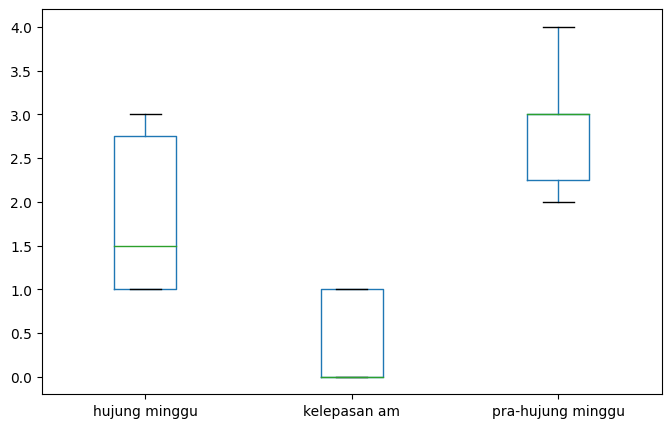

In [173]:
pd.DataFrame.from_dict({k: [values for key, values in v.items()] for k, v in c.fairness_detail_weekend_holiday.items()}).T.rename(columns={0: "hujung minggu", 1: "kelepasan am", 2: "pra-hujung minggu"}).boxplot(figsize=(8,5), grid=False)

<AxesSubplot: >

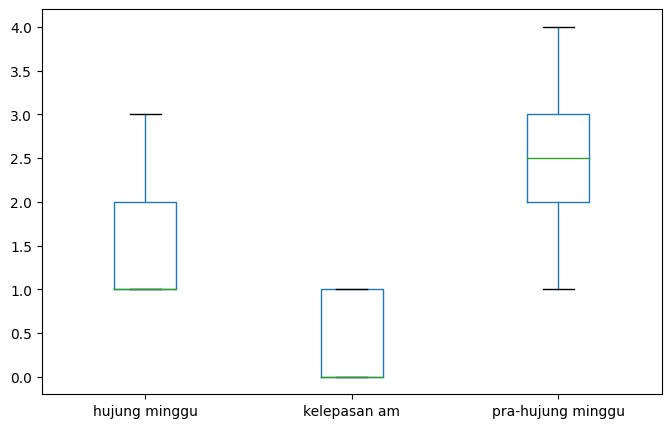

In [174]:
pd.DataFrame.from_dict({k: [values for key, values in v.items()] for k, v in d.fairness_detail_weekend_holiday.items()}).T.rename(columns={0: "hujung minggu", 1: "kelepasan am", 2: "pra-hujung minggu"}).boxplot(figsize=(8,5), grid=False)

In [83]:
c.df_solution

,2022-07-11,2022-07-12,2022-07-13,2022-07-14,2022-07-15,2022-07-16,2022-07-17,2022-07-18,2022-07-19,2022-07-20,2022-07-21,2022-07-22,2022-07-23,2022-07-24
J1,DOP,AL,AMS,AM,AMS,AL,DO,PM,PM,PM,N,N,NO,DO
J2,DOP,AL,PM,PM,PM,AM,DO,PM,AM,AM,AMS,PM,AL,DO
J3,DOP,PM,PM,PM,PM,DO,AM,AM,AM,AM,AMS,AM,AL,DO
J4,PM,AMS,N,N,NO,AM,DO,AM,AM,AMS,PM,PM,AM,DO
J5,NO,AM,AM,AM,AMS,AM,DO,PM,PM,PM,AL,AL,PM,DO
J6,DOP,PM,PM,PM,PM,AM,N,N,NO,DO,PM,AMS,DO,PM
J7,DOP,AL,AMS,AM,AM,DO,PM,AMS,AM,AM,AMS,AM,N,N
J8,N,N,NO,PM,PM,PM,DO,PM,PM,PM,PM,PM,AL,DO
J9,AM,PM,PM,AMS,N,N,NO,AM,AMS,AM,AL,DO,DO,AM
J10,DOP,AMS,AM,AMS,AM,AM,DO,AM,N,N,NO,AL,DO,DO


In [104]:
d.df_solution
# .to_csv('jadual_data/model_output.csv')

,2022-07-11,2022-07-12,2022-07-13,2022-07-14,2022-07-15,2022-07-16,2022-07-17,2022-07-18,2022-07-19,2022-07-20,2022-07-21,2022-07-22,2022-07-23,2022-07-24
J1,DOP,AL,AMS,N,NO,AL,DO,N,NO,AMS,PM,AM,DO,AM
J2,PM,AL,AM,AM,AMS,DO,N,NO,PM,AMS,PM,PM,AL,DO
J3,DO,PM,PM,PM,AMS,N,NO,PM,N,NO,AMS,DO,AL,PM
J4,DOP,AMS,N,NO,PM,PM,DO,DO,AMS,PM,AM,PM,N,NO
J5,NO,PM,PM,AMS,AM,DO,PM,AM,AM,AM,AL,AL,DO,N
J6,DOP,N,NO,AM,PM,DOP,DO,PM,PM,N,NO,AMS,AM,DO
J7,DOP,AL,AMS,PM,PM,DO,AM,AMS,AM,PM,PM,N,NO,DO
J8,DOP,PM,AM,PM,AM,AM,DO,AMS,AM,AM,N,NO,AL,DO
J9,AM,AM,PM,AM,N,NO,DO,AM,AMS,AM,AL,PM,DO,DOP
J10,N,NO,AM,AMS,AM,DOP,DO,PM,PM,PM,AM,AL,PM,DO


In [86]:
c.rest_time_between_shift

{'J1': datetime.timedelta(seconds=60923, microseconds=76923),
 'J2': datetime.timedelta(seconds=60646, microseconds=153846),
 'J3': datetime.timedelta(seconds=46246, microseconds=153846),
 'J4': datetime.timedelta(seconds=63692, microseconds=307692),
 'J5': datetime.timedelta(seconds=57876, microseconds=923077),
 'J6': datetime.timedelta(seconds=59815, microseconds=384615),
 'J7': datetime.timedelta(seconds=69507, microseconds=692308),
 'J8': datetime.timedelta(seconds=60646, microseconds=153846),
 'J9': datetime.timedelta(seconds=64800),
 'J10': datetime.timedelta(seconds=40984, microseconds=615385),
 'average': datetime.timedelta(seconds=58513, microseconds=846154)}

In [87]:
d.rest_time_between_shift

{'J1': datetime.timedelta(seconds=77261, microseconds=538462),
 'J2': datetime.timedelta(seconds=63692, microseconds=307692),
 'J3': datetime.timedelta(seconds=76153, microseconds=846154),
 'J4': datetime.timedelta(seconds=66738, microseconds=461538),
 'J5': datetime.timedelta(seconds=55938, microseconds=461538),
 'J6': datetime.timedelta(seconds=69507, microseconds=692308),
 'J7': datetime.timedelta(seconds=61753, microseconds=846154),
 'J8': datetime.timedelta(seconds=45415, microseconds=384615),
 'J9': datetime.timedelta(seconds=57876, microseconds=923077),
 'J10': datetime.timedelta(seconds=66461, microseconds=538462),
 'average': datetime.timedelta(seconds=64080)}

<AxesSubplot: >

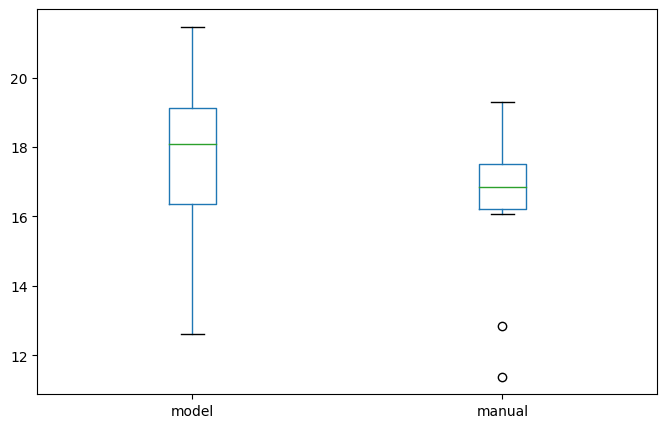

In [88]:
model = {k: v.seconds/60/60 for k, v in d.rest_time_between_shift.items()}
manual = {k: v.seconds/60/60 for k, v in c.rest_time_between_shift.items()}
df_model = pd.DataFrame.from_dict(data, orient='index', columns=['model'])
df_manual = pd.DataFrame.from_dict(manual, orient='index', columns=['manual'])
df = pd.concat([df_model,df_manual], axis=1).iloc[:-1,:]
df.boxplot(figsize=(8,5), grid=False)

In [168]:
manual

{'J1': 16.923055555555557,
 'J2': 16.84611111111111,
 'J3': 12.84611111111111,
 'J4': 17.69222222222222,
 'J5': 16.076666666666668,
 'J6': 16.615277777777777,
 'J7': 19.3075,
 'J8': 16.84611111111111,
 'J9': 18.0,
 'J10': 11.384444444444446,
 'average': 16.253611111111113}

In [169]:
model

{'J1': 21.46138888888889,
 'J2': 17.69222222222222,
 'J3': 21.15361111111111,
 'J4': 18.538333333333334,
 'J5': 15.538333333333332,
 'J6': 19.3075,
 'J7': 17.15361111111111,
 'J8': 12.615277777777777,
 'J9': 16.076666666666668,
 'J10': 18.46138888888889,
 'average': 17.8}

In [89]:
c.df_shift_count_each_day[m._date_range]

,2022-07-11,2022-07-12,2022-07-13,2022-07-14,2022-07-15,2022-07-16,2022-07-17,2022-07-18,2022-07-19,2022-07-20,2022-07-21,2022-07-22,2022-07-23,2022-07-24
DOP,6,0,0,0,0,0,0,0,0,0,0,0,0,0
PM,1,3,4,4,4,1,1,4,3,3,3,3,1,1
NO,1,0,1,0,1,0,1,0,1,0,1,0,1,0
N,1,1,1,1,1,1,1,1,1,1,1,1,1,1
AM,1,1,2,3,2,5,1,4,4,4,0,2,1,1
AL,0,3,0,0,0,1,0,0,0,0,2,2,3,0
AMS,0,2,2,2,2,0,0,1,1,1,3,1,0,0
DO,0,0,0,0,0,2,6,0,0,1,0,1,3,7


In [90]:
d.df_shift_count_each_day[m._date_range]

,2022-07-11,2022-07-12,2022-07-13,2022-07-14,2022-07-15,2022-07-16,2022-07-17,2022-07-18,2022-07-19,2022-07-20,2022-07-21,2022-07-22,2022-07-23,2022-07-24
DOP,5,0,0,0,0,2,0,0,0,0,0,0,0,1
PM,1,3,3,3,3,1,1,3,3,3,3,3,1,1
DO,1,0,0,0,0,3,6,1,0,0,0,1,3,5
NO,1,1,1,1,1,1,1,1,1,1,1,1,1,1
AM,1,1,3,3,3,1,1,2,3,3,2,1,1,1
N,1,1,1,1,1,1,1,1,1,1,1,1,1,1
AL,0,3,0,0,0,1,0,0,0,0,2,2,3,0
AMS,0,1,2,2,2,0,0,2,2,2,1,1,0,0


<AxesSubplot: >

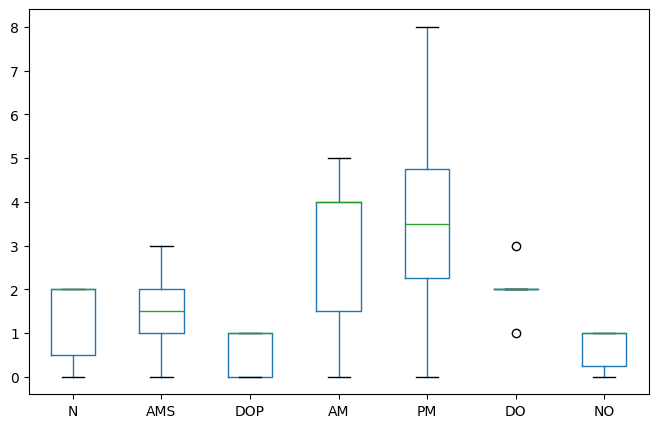

In [91]:
cols = [n,ams,dop,am,pm,do,no]
c.df_shift_count_each_nurse.T[cols].boxplot(figsize=(8,5), grid=False)

<AxesSubplot: >

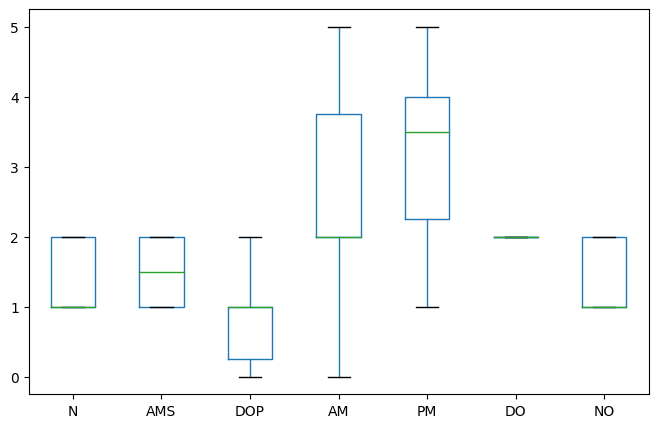

In [92]:
d.df_shift_count_each_nurse.T[cols].boxplot(figsize=(8,5), grid=False)

<AxesSubplot: >

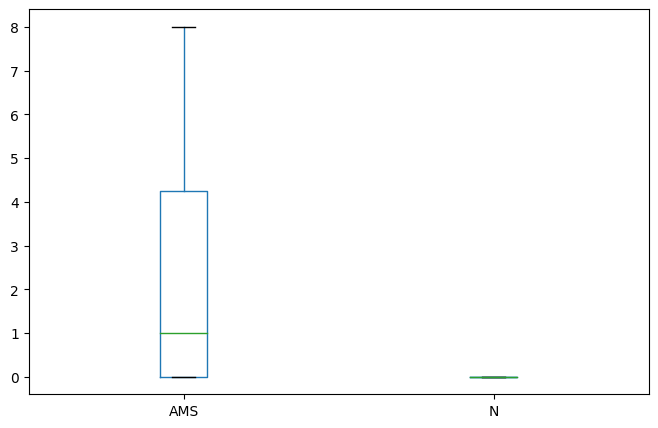

In [102]:
c.df_gap_between_shift_each_nurse.T[[ams,n]].boxplot(figsize=(8,5), grid=False)

<AxesSubplot: >

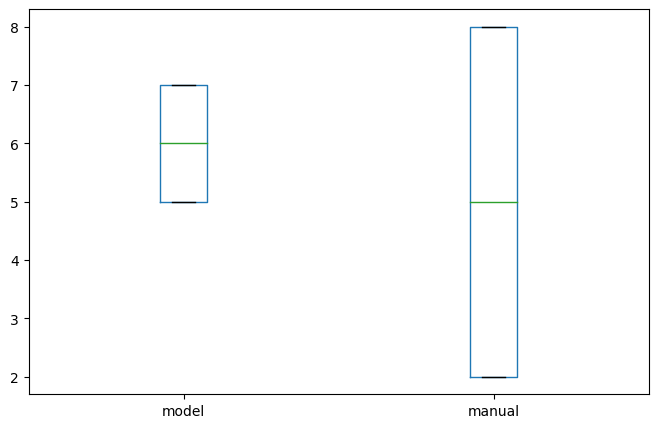

In [124]:
ams_gap = pd.concat([d.df_gap_between_shift_each_nurse.T[[ams]].rename(columns={"AMS": "model"}), c.df_gap_between_shift_each_nurse.T[[ams]].rename(columns={"AMS": "manual"})], axis=1)
ams_gap[ams_gap != 0].boxplot(figsize=(8,5), grid=False)

<AxesSubplot: >

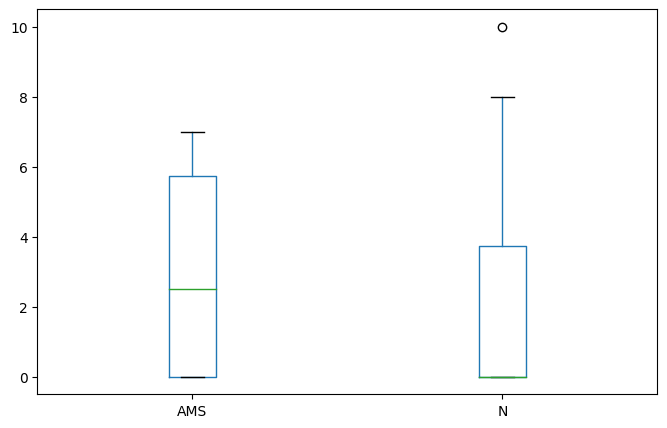

In [103]:
d.df_gap_between_shift_each_nurse.T[[ams,n]].boxplot(figsize=(8,5), grid=False)

In [95]:
c.post_night_rest

{'J1': 0,
 'J2': 0,
 'J3': 0,
 'J4': '1 days, 0 hours, 0 mins',
 'J5': 0,
 'J6': '2 days, 7 hours, 0 mins',
 'J7': 0,
 'J8': '1 days, 7 hours, 0 mins',
 'J9': '1 days, 0 hours, 0 mins',
 'J10': '2 days, 16 hours, 0 mins',
 'average': '1 days, 15 hours, 36 mins'}

In [96]:
d.post_night_rest

{'J1': '1 days, 20 hours, 0 mins',
 'J2': '1 days, 7 hours, 0 mins',
 'J3': '1 days, 3 hours, 30 mins',
 'J4': '1 days, 7 hours, 0 mins',
 'J5': 0,
 'J6': '1 days, 0 hours, 0 mins',
 'J7': 0,
 'J8': '2 days, 16 hours, 0 mins',
 'J9': '2 days, 0 hours, 0 mins',
 'J10': '1 days, 0 hours, 0 mins',
 'average': '1 days, 12 hours, 41 mins'}

In [97]:
print(f'always/max transition correct {c.max_or_always_transition_correct}')
print(f'always/max transition wrong {c.max_or_always_transition_wrong}')
print(f'never transition correct {c.never_transition_correct}')
print(f'never transition wrong {c.never_transition_wrong}')

always/max transition correct 15
always/max transition wrong 36
never transition correct 128
never transition wrong 3


In [98]:
print(f'always/max transition correct {d.max_or_always_transition_correct}')
print(f'always/max transition wrong {d.max_or_always_transition_wrong}')
print(f'never transition correct {d.never_transition_correct}')
print(f'never transition wrong {d.never_transition_wrong}')

always/max transition correct 24
always/max transition wrong 41
never transition correct 141
never transition wrong 2


In [99]:
c.details

{'N to NO wrong always': 7,
 'N to NO correct always': 6,
 'NO to PM wrong max': 6,
 'NO to DO correct max': 2,
 'AL to DO wrong max': 5,
 'AL to DO correct max': 6,
 'DO to AL wrong max': 13,
 'NO to AM correct min': 4,
 'NO to N correct never': 7,
 'NO to NO correct never': 7,
 'PM to NO correct never': 35,
 'AM to NO correct never': 30,
 'DO to NO correct never': 13,
 'DOP to NO correct never': 6,
 'AMS to NO correct never': 15,
 'AL to NO correct never': 11,
 'NO to DO wrong max': 5,
 'NO to AM wrong min': 3,
 'NO to PM correct max': 1}

In [100]:
d.details

{'N to NO correct always': 13,
 'NO to PM wrong max': 9,
 'NO to DO wrong max': 11,
 'AL to DO wrong max': 7,
 'AL to DO correct max': 4,
 'DO to AL wrong max': 14,
 'NO to AM correct min': 11,
 'NO to N correct never': 13,
 'NO to NO correct never': 13,
 'PM to NO correct never': 31,
 'AM to NO correct never': 25,
 'DO to NO correct never': 15,
 'DOP to NO correct never': 7,
 'AMS to NO correct never': 15,
 'AL to NO correct never': 11,
 'NO to PM correct max': 4,
 'DO to AL correct max': 1,
 'NO to AM wrong min': 2,
 'NO to DO correct max': 2}

In [24]:
# # for item in d.df_solution.itertuples():
# #     print(item.Index, item)
# def update_weekend_counts(self, data, date, nurse, shift, date_type):
#     data[nurse].setdefault(date_type, 0)
#     if shift not in [no, do, al]:
#         data[nurse][date_type] += 1
    
# def get_weekend_pre_weekend(self):
#     data = {}
#     for item in self.df_solution.items():
#         date = item[0]
#         for item_series in item[1].iteritems():
#             data.setdefault(item_series[0], {})
#             if malaysia.is_holiday(date):
#                 self.update_weekend_counts(data, date, item_series[0], item_series[1], 'public holiday')
#             elif malaysia.is_holiday(utils.add_days(date, 1)):
#                 self.update_weekend_counts(data, date, item_series[0], item_series[1], 'pre public holiday')
#             elif utils.is_weekend(date):
#                 self.update_weekend_counts(data, date, item_series[0], item_series[1], 'weekend')
#             elif utils.is_weekend(utils.add_days(date, 1)):
#                 self.update_weekend_counts(data, date, item_series[0], item_series[1], 'pre weekend')
#             else:
#                 pass
#     return pd.DataFrame(data)
#         # print('is public holiday', malaysia.is_holiday(date))
#         # print('is pre-public holiday', malaysia.is_holiday(utils.add_days(date, 1)))
#         # print('is weekend', utils.is_weekend(date))
#         # print('is pre-weekend', utils.is_weekend(utils.add_days(date, 1)))

In [25]:
shift_timings

{'AM': {'start': datetime.time(7, 0), 'end': datetime.time(14, 0)},
 'AMS': {'start': datetime.time(7, 0), 'end': datetime.time(17, 0)},
 'PM': {'start': datetime.time(14, 0), 'end': datetime.time(21, 0)},
 'N': {'start': datetime.time(21, 0), 'end': datetime.time(0, 0)},
 'NO': {'start': datetime.time(0, 0), 'end': datetime.time(7, 0)},
 'AL': {'start': datetime.time(23, 0), 'end': datetime.time(0, 0)},
 'DO': {'start': datetime.time(23, 0), 'end': datetime.time(0, 0)},
 'DOP': {'start': datetime.time(23, 0), 'end': datetime.time(0, 0)}}

In [ ]:
    def is_pre_weekend(self, d):
        return utils.is_weekend(d + datetime.timedelta(days=1))

    def is_pre_holiday(self, d):
        return malaysia.is_holiday(d + datetime.timedelta(days=1))

    def is_working_on_holiday(self, nurse, function, category):
        self.fairness_detail_weekend_holiday.setdefault(nurse, {})
        arr = self.solution[nurse]
        arr_to_check = [function(d) for d in self._date_range]
        shift_on_the_date = list(compress(arr, arr_to_check))
        working_shift_on_the_date = [shift for shift in shift_on_the_date if shift in [am, ams, pm, n, no]]
        num_working = len(working_shift_on_the_date)
        self.fairness_detail_weekend_holiday[nurse][category] = num_working

    def get_weekend_holiday_fairness_all_shift(self):
        for nurse in self.nurses:
            self.is_working_on_holiday(nurse, utils.is_weekend, 'weekend')
            self.is_working_on_holiday(nurse, malaysia.is_holiday, 'holiday')
            self.is_working_on_holiday(nurse, self.is_pre_holiday, 'pre-holiday')
            self.is_working_on_holiday(nurse, self.is_pre_weekend, 'pre-weekend')

In [131]:
from itertools import compress

    arr = m.solution[nurse]
    arr_to_check = [malaysia.is_holiday(d) for d in m._date_range]
    shift_on_the_date = list(compress(arr, arr_to_check))
    working_shift_on_the_date = [shift for shift in shift_on_the_date if shift in [am, ams, pm, n, no]]
    return len(working_shift_on_the_date)

False

In [ ]:
for shift in list():
    if shift in []:
[shift for shift in list() if shift in []]